In [1]:
import pandas as pd
import pyarrow as pa
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import ranksums, ttest_ind
import umap
from sklearn.preprocessing import StandardScaler
import numpy as np

/home/kradja/miniforge3/envs/prefect3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
data = Path("./").resolve().parent / "data"
concat_breast = data / "concat_breast_df_patient.pkl"
concat_lung= data / "concat_lung_df_patient.pkl"
if concat_breast.exists():
    bdf = pd.read_pickle(concat_breast).reset_index()
if concat_lung.exists():
    ldf = pd.read_pickle(concat_lung).reset_index()

In [3]:
bdf_desc = bdf.describe()
ldf_desc = ldf.describe()

In [7]:
filt_bdf = bdf[bdf["Nucleus: Area"] >= 38.45]
filt_bdf = filt_bdf[filt_bdf["Nucleus: Area"] <= 78.5]
filt_bdf = filt_bdf[filt_bdf["Nucleus: Hematoxylin OD mean"] >= 0.75]
filt_bdf.to_csv(data / "breast_filtered_tils_patient.csv")
# Lung
filt_ldf = ldf[ldf["Nucleus: Area"] >= 38.45]
filt_ldf = filt_ldf[filt_ldf["Nucleus: Area"] <= 78.5]
filt_ldf = filt_ldf[filt_ldf["Nucleus: Hematoxylin OD mean"] >= 0.75]
filt_ldf.to_csv(data / "lung_filtered_tils_patient.csv")

In [26]:
#filt_ldf.index.levels[1].value_counts()
#fl = filt_ldf.reset_index()
#all_fl = ldf.reset_index()
#bl = filt_bdf.reset_index()
#all_bl = bdf.reset_index()

In [16]:
def print_value_counts(df, index_name, df_type, percentage=False, ):
    vc = df[index_name].value_counts()
    if percentage:
        vc = vc / len(df) * 100
    print(f"This is the value counts for {df_type}")
    print(f"\t{vc.index.tolist()}\n{vc.tolist()}\n")

print_value_counts(filt_ldf, "level_0", percentage=True, "Filtered Lung")
print_value_counts(filt_bdf, "level_0", percentage=True, "Filtered Breast")
print_value_counts(ldf, "level_0", percentage=True, "Lung")
print_value_counts(bdf, "level_0", percentage=True, "Breast")
#resfl = ldf.level_0.value_counts() / len(ldf) * 100
#resbl = bdf.level_0.value_counts() / len(bdf) * 100 
#resfl.sort_index(inplace=True)
#resbl.sort_index(inplace=True)
#print(f"\t{resfl.index.tolist()}\n{resfl.tolist()}")
#print(f"\t{resbl.index.tolist()}\n{resbl.tolist()}")

AttributeError: 'DataFrame' object has no attribute 'name'

In [13]:
print(filt_ldf.level_0.value_counts())
print(ldf.level_0.value_counts())
print(filt_bdf.level_0.value_counts())
print(bdf.level_0.value_counts())

level_0
LUAD-1    35093
LUAD-3     4554
LUAD-2     3651
LUAD-5      827
LUAD-4      527
Name: count, dtype: int64
level_0
LUAD-2    762380
LUAD-5    602898
LUAD-1    599693
LUAD-3    262834
LUAD-4    194196
Name: count, dtype: int64
level_0
BRCA-2    4744
BRCA-1    1255
BRCA-3     377
BRCA-5     347
BRCA-4     240
Name: count, dtype: int64
level_0
BRCA-3    991944
BRCA-4    535901
BRCA-1    504149
BRCA-2    431832
BRCA-5    118553
Name: count, dtype: int64


In [30]:
def col_df(colname: str,bdf: pd.DataFrame, ldf: pd.DataFrame) -> pd.DataFrame:
    tmpb = bdf[colname].reset_index(drop=True).rename("Breast")
    tmpl = ldf[colname].reset_index(drop=True).rename("Lung")
    return pd.concat([tmpb, tmpl],axis=1)

In [31]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

9.638434642398304e-79


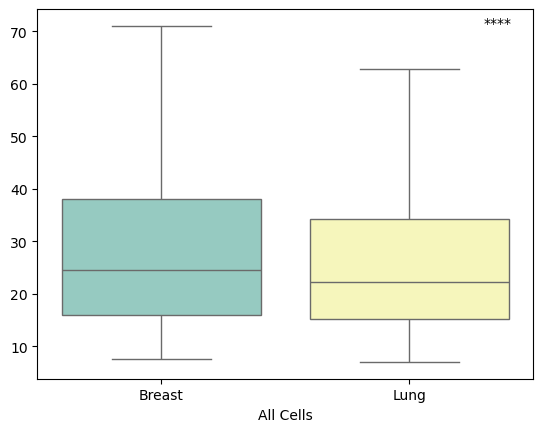

In [32]:
nucl_area = col_df("Nucleus: Area", bdf,ldf)
ttest_res = ttest_ind(nucl_area["Breast"].dropna(), nucl_area["Lung"].dropna())
print(ttest_res.pvalue)
plt.figure()
sns.boxplot(data=nucl_area, showfliers=False, palette="Set3")
if ttest_res.pvalue < 0.05:
    plt.text(0.9,0.95,convert_pvalue_to_asterisks(ttest_res.pvalue), transform=plt.gca().transAxes)
plt.xlabel("All Cells")
plt.show()

1.3927870211552005e-05


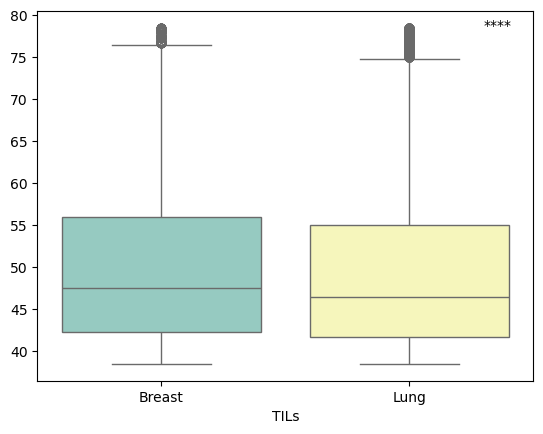

In [33]:
nucl_area_til = col_df("Nucleus: Area", filt_bdf,filt_ldf)
ttest_res = ttest_ind(nucl_area_til["Breast"].dropna(), nucl_area_til["Lung"].dropna())
print(ttest_res.pvalue)
plt.figure()
sns.boxplot(data=nucl_area_til, showfliers=True, palette="Set3")
if ttest_res.pvalue < 0.05:
    plt.text(0.9,0.95,convert_pvalue_to_asterisks(ttest_res.pvalue), transform=plt.gca().transAxes)
plt.xlabel("TILs")
plt.show()

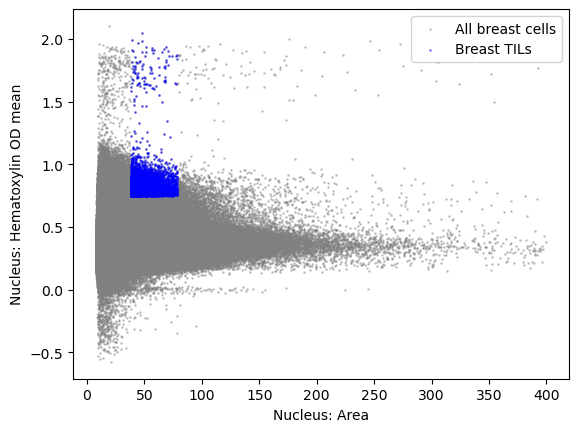

In [34]:
plt.figure()
plt.scatter(bdf["Nucleus: Area"], bdf["Nucleus: Hematoxylin OD mean"], color="grey",alpha=0.4,s=0.8)
plt.scatter(filt_bdf["Nucleus: Area"], filt_bdf["Nucleus: Hematoxylin OD mean"], color="blue",alpha=0.4,s=0.9)
plt.ylabel("Nucleus: Hematoxylin OD mean")
plt.xlabel("Nucleus: Area")
plt.legend(["All breast cells", "Breast TILs"], loc="upper right")
plt.show()

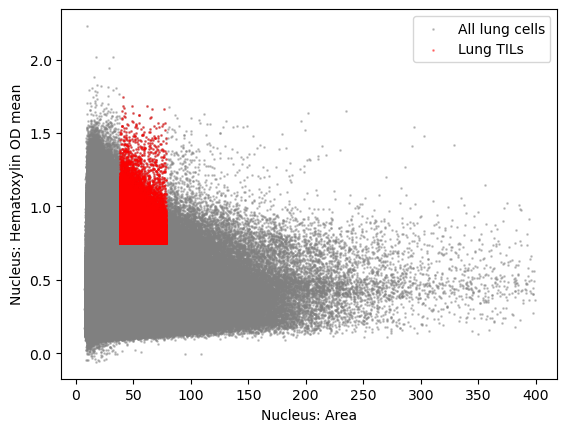

In [35]:
plt.figure()
plt.scatter(ldf["Nucleus: Area"], ldf["Nucleus: Hematoxylin OD mean"],color="grey",alpha=0.4,s=0.9)
plt.scatter(filt_ldf["Nucleus: Area"], filt_ldf["Nucleus: Hematoxylin OD mean"], color="red",alpha=0.4,s=0.9)
plt.ylabel("Nucleus: Hematoxylin OD mean")
plt.xlabel("Nucleus: Area")
plt.legend(["All lung cells", "Lung TILs"])
plt.show()

In [36]:
print(len(filt_bdf) / len(bdf))
print(len(filt_ldf) / len(ldf))


0.0026963509229280445
0.018435995691166107


In [37]:
filt_bdf["Tissue"] = "Breast"
filt_ldf["Tissue"] = "Lung"
concat_tils = pd.concat([filt_bdf, filt_ldf], axis=0)
cols_list = list(concat_tils.columns)

In [49]:
#concat_tils[cols_list[7:-1]].head()
ctils = concat_tils[cols_list[7:-1]].reset_index().drop("level_1", axis=1).rename(columns={"level_0": "Patient"})
ctils_shape = ctils[["Patient"] + cols_list[7:15]]
ctils_hema = ctils[["Patient"] + cols_list[15:21]]
ctils_eosin = ctils[["Patient"] + cols_list[21:27]]

In [53]:
ctils_shape.head()

,Patient,Centroid X µm,Centroid Y µm,Nucleus: Area,Nucleus: Perimeter,Nucleus: Circularity,Nucleus: Max caliper,Nucleus: Min caliper,Nucleus: Eccentricity
0,BRCA-1,7007.0,2111.0,38.75,28.5197,0.5987,9.764,6.3683,0.7935
1,BRCA-1,6926.4,2155.7,42.75,29.5901,0.6136,10.435,6.7555,0.7616
2,BRCA-1,7011.0,2181.8,42.75,27.4674,0.7121,10.3832,5.82,0.8594
3,BRCA-1,6898.1,2186.0,44.75,28.2895,0.7027,11.854,5.6924,0.907
4,BRCA-1,6985.9,2188.4,40.5,32.3913,0.4851,9.304,8.2968,0.5122


In [95]:
def umap_embedding(input_df: pd.DataFrame) -> pd.DataFrame:
    patient_types = set(input_df.Patient)
    scaled_tils= StandardScaler().fit_transform(input_df.drop("Patient", axis=1))
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(scaled_tils)
    breast_embeds = [(x , embedding[input_df.Patient == x]) for x in patient_types if "BRCA" in x]
    lung_embeds = [(x , embedding[input_df.Patient == x]) for x in patient_types if "LUAD" in x]
    return breast_embeds, lung_embeds

ctils_shape_drop1 = ctils_shape[ctils_shape.Patient != "LUAD-1"]
breast_embed_sdrop1, lung_embed_sdrop1 = umap_embedding(ctils_shape_drop1)
breast_embed_shape, lung_embed_shape = umap_embedding(ctils_shape)
breast_embed_hema, lung_embed_hema = umap_embedding(ctils_hema)
breast_embed_eosin, lung_embed_eosin = umap_embedding(ctils_eosin)


In [102]:
breast_embed, lung_embed = umap_embedding(ctils)
all_breast_embed, all_lung_embed = umap_embedding()

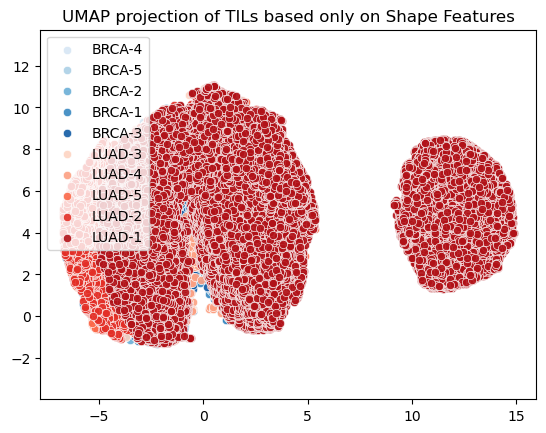

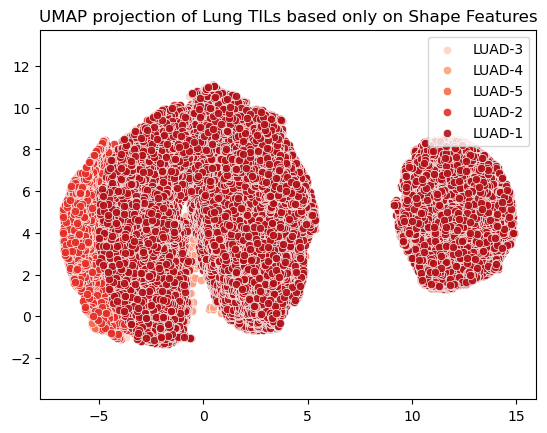

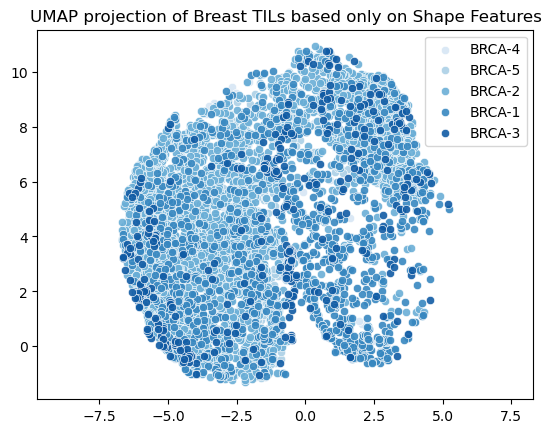

In [ ]:
def plot_scatter(breast_embeds, lung_embeds, title_str,lung_only=False, breast_only=False):
    blue4 = sns.color_palette("Blues", 5)
    red4 = sns.color_palette("Reds", 5)
    hls = sns.color_palette("hls", 10)
    plt.figure()
    if not lung_only:
        [ sns.scatterplot(x=x[1][:,0], y=x[1][:,1], alpha=0.9,color = blue4[i], label=x[0]) for i,x in enumerate(breast_embeds) ]
    if not breast_only:
        [ sns.scatterplot(x=x[1][:,0], y=x[1][:,1], alpha=0.9,color = red4[i], label=x[0]) for i,x in enumerate(lung_embeds) ]
    plt.gca().set_aspect('equal', 'datalim')
    plt.legend()
    plt.title(title_str)
    plt.show()
    plt.close()

plot_scatter(breast_embed_shape, lung_embed_shape, "UMAP projection of TILs based only on Shape Features")
plot_scatter(breast_embed_shape, lung_embed_shape, "UMAP projection of Lung TILs based only on Shape Features", lung_only=True)
plot_scatter(breast_embed_shape, lung_embed_shape, "UMAP projection of Breast TILs based only on Shape Features", breast_only=True)

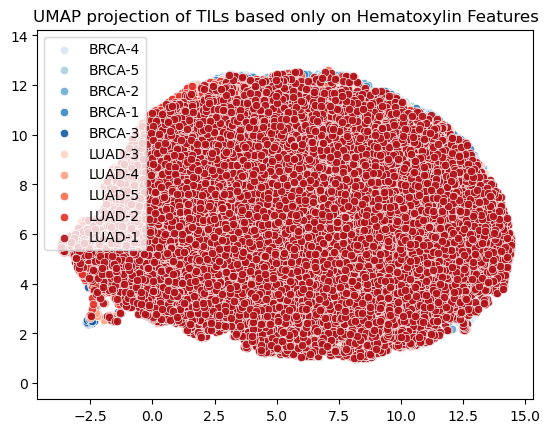

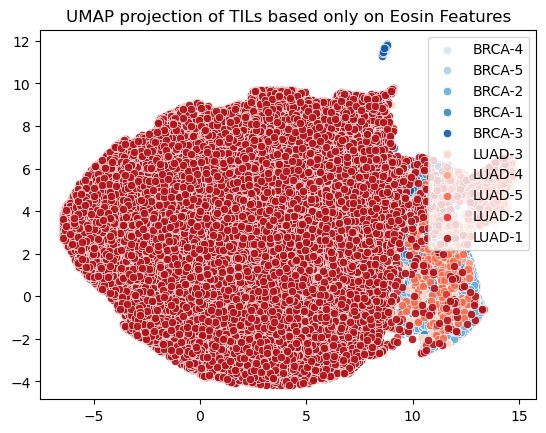

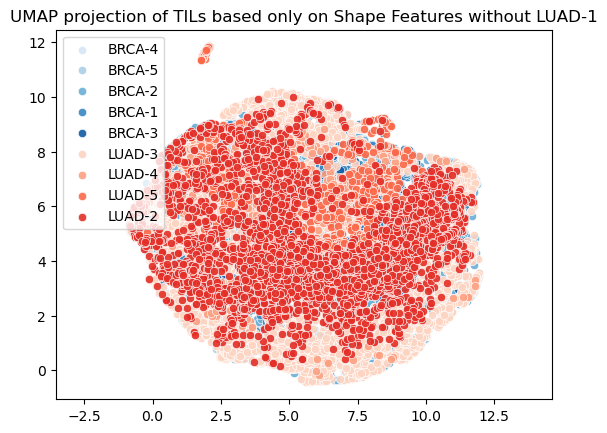

In [101]:
plot_scatter(breast_embed_hema, lung_embed_hema, "UMAP projection of TILs based only on Hematoxylin Features")
plot_scatter(breast_embed_eosin, lung_embed_eosin, "UMAP projection of TILs based only on Eosin Features")
plot_scatter(breast_embed_sdrop1, lung_embed_sdrop1, "UMAP projection of TILs based only on Shape Features without LUAD-1")

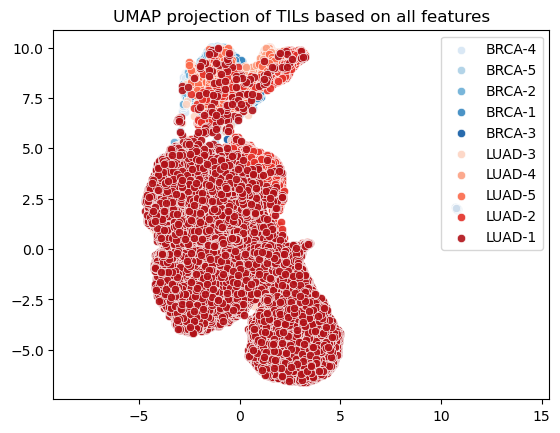

In [ ]:
plot_scatter(breast_embed, lung_embed, "UMAP projection of TILs based on all features")

In [104]:
ctils.head()

,Patient,Centroid X µm,Centroid Y µm,Nucleus: Area,Nucleus: Perimeter,Nucleus: Circularity,Nucleus: Max caliper,Nucleus: Min caliper,Nucleus: Eccentricity,Nucleus: Hematoxylin OD mean,...,Nucleus: Hematoxylin OD std dev,Nucleus: Hematoxylin OD max,Nucleus: Hematoxylin OD min,Nucleus: Hematoxylin OD range,Nucleus: Eosin OD mean,Nucleus: Eosin OD sum,Nucleus: Eosin OD std dev,Nucleus: Eosin OD max,Nucleus: Eosin OD min,Nucleus: Eosin OD range
0,BRCA-1,7007.0,2111.0,38.75,28.5197,0.5987,9.764,6.3683,0.7935,0.7912,...,0.1224,1.0795,0.3505,0.7289,0.5155,82.9917,0.1577,0.8367,-0.067,0.9037
1,BRCA-1,6926.4,2155.7,42.75,29.5901,0.6136,10.435,6.7555,0.7616,0.795,...,0.1682,1.2631,0.3857,0.8774,0.4759,81.8607,0.1984,0.9115,-0.2009,1.1124
2,BRCA-1,7011.0,2181.8,42.75,27.4674,0.7121,10.3832,5.82,0.8594,0.8547,...,0.1557,1.3234,0.3688,0.9546,0.5486,95.4627,0.2083,1.0336,-0.1952,1.2288
3,BRCA-1,6898.1,2186.0,44.75,28.2895,0.7027,11.854,5.6924,0.907,0.8418,...,0.1548,1.2688,0.3933,0.8754,0.5331,97.0282,0.1648,0.8517,-0.0364,0.8881
4,BRCA-1,6985.9,2188.4,40.5,32.3913,0.4851,9.304,8.2968,0.5122,0.7741,...,0.1724,1.1637,0.208,0.9557,0.4819,79.028,0.1749,0.8531,-0.1026,0.9557


In [115]:
from sklearn.svm import OneClassSVM
def onesvm(input_df):
    scaled_tils= StandardScaler().fit_transform(input_df.drop("Patient", axis=1))
    model = OneClassSVM(nu=0.1, kernel='rbf', gamma='scale')
    model.fit(scaled_tils)
    outliers = model.predict(scaled_tils)
    return outliers
breast_total = ctils[ctils.Patient.str.contains("BRCA")]
lung_total = ctils[ctils.Patient.str.contains("LUAD")]
breast_outliers = onesvm(breast_total)
lung_outliers = onesvm(lung_total)

In [ ]:
bt_svm = breast_total.Patient[breast_outliers == -1].value_counts()
lt_svm = lung_total.Patient[lung_outliers == -1].value_counts()
#print(bt_svm)
#print(bt_svm / len(breast_total) * 100)
#print(f"Percentage of outliers {len(np.where(breast_outliers == -1)[0]) / len(breast_outliers) * 100}")
print(lt_svm)
print(lt_svm / len(lung_total) * 100)
print(f"Percentage of outliers {len(np.where(lung_outliers == -1)[0]) / len(lung_outliers) * 100}")

Patient
LUAD-1    2268
LUAD-2     783
LUAD-5     628
LUAD-4     501
LUAD-3     286
Name: count, dtype: int64
Patient
LUAD-1    5.079280
LUAD-2    1.753561
LUAD-5    1.406432
LUAD-4    1.122010
LUAD-3    0.640509
Name: count, dtype: float64
Percentage of outliers 10.001791633073546


In [111]:
breast_total.shape

(6963, 21)

In [23]:

ranksums(filt_bdf["Nucleus: Area"], filt_ldf["Nucleus: Area"])

RanksumsResult(statistic=5.352904888841326, pvalue=8.655334935188115e-08)